# Task
Пробую определять T путем перебора. Строю Validation Curve.

Смотрю на результаты.

Задача: Поднять значение метрики Precision

# Import modules

In [1]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import OneHotEncoder, BinaryEncoder

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

# Load Data

In [3]:
data = pd.read_parquet('..\ETH-Full-1H.parquet')

In [4]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


In [5]:
df

,Open,High,Low,Close,Volume,Trades
Datetime,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128
...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824


# Base Visualization

In [6]:
# # If need to plot not all data
# # df_to_plot = df[df.index >= '2018-01-01']
# df_to_plot = df

# # Create a 2-row, 1-column subplot grid
# fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# # Convert series to numpy
# ind = df_to_plot.index.to_numpy()
# _0 = df_to_plot['Close'].to_numpy()
# _1 = df_to_plot['Volume'].to_numpy()
# _2 = df_to_plot['Trades'].to_numpy()

# ax[0].plot(ind, _0, linewidth=1)
# ax[0].set_title('Close')

# ax[1].fill_between(ind, _1, step='pre')
# ax[1].set_title('Volume')

# ax[2].fill_between(ind, _2, step='pre')
# ax[2].set_title('Trades')

# # Set the x-axis label for the entire figure
# plt.xlabel('Date')

# # Adjust the layout and show the plot
# plt.tight_layout()
# plt.show()

В 17 году совсем маленькие объемы, подрежу данные. Не буду брать то что до 18 года

In [7]:
df = df[df.index >= '2018-01-01'].copy()

### Провека всех признаков исходного ряда на стационарность

In [8]:
# for col_name, col_data in df.items():
#     print("Column Name : ", col_name)
#     hd.adf(col_data.values)
#     print()

Volume, Trades стационарны и то, значения пограничные. Надо преобразовывать.

# Feature Enginiring
Логарифмирую все признаки

In [9]:
cols = df.columns
for col in cols:
    df[col + '_log'] = np.log(df[col])

# df.drop(columns=cols, inplace=True) # удаляю все старые признаки

In [10]:
df

,Open,High,Low,Close,Volume,Trades,Open_log,High_log,Low_log,Close_log,Volume_log,Trades_log
Datetime,,,,,,,,,,,,
2018-01-01 00:00:00,733.01,734.52,720.03,727.62,2105.90100,3114,6.597159,6.599217,6.579293,6.589779,7.652499,8.043663
2018-01-01 01:00:00,727.01,732.00,716.80,717.97,2305.97086,2875,6.588940,6.595781,6.574797,6.576428,7.743257,7.963808
2018-01-01 02:00:00,717.67,725.75,717.59,724.05,2166.45725,2957,6.576010,6.587206,6.575898,6.584860,7.680849,7.991931
2018-01-01 03:00:00,723.95,737.99,722.70,734.50,2160.90450,3647,6.584722,6.603930,6.582994,6.599190,7.678282,8.201660
2018-01-01 04:00:00,734.99,744.98,730.01,744.82,2335.33705,3512,6.599857,6.613357,6.593058,6.613143,7.755912,8.163941
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648,7.521188,7.524210,7.520191,7.521042,9.714152,9.982668
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445,7.521042,7.524183,7.516450,7.522341,9.481396,9.875345
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824,7.522335,7.527966,7.521637,7.525457,8.968984,9.534161


Тени от открытия бара на лог шкале

In [11]:
df['Low_Shad_log'] = df['Open_log'] - df['Low_log']
df['High_Shad_log'] = df['High_log'] - df['Open_log']

Прирост за бар на лог шкале

Фактически это аналог first log difference

Прирост и тени от открытия бара, т.к. в истории есть пропуски по много часов и они могут давать сильные искажения, вылеты для таргетов

In [12]:
df['Log_Return'] = df['Close_log'] - df['Open_log']

Диапазон бара логарифмический

In [13]:
df['Log_Range'] = df['High_log'] - df['Low_log']
df['Range_diff'] = df['Log_Range'].diff()

Прирост объема и количества сделок

In [14]:
df['Diff_Vol_log'] = df['Volume_log'].diff()
df['Diff_Trade_log'] = df['Volume_log'].diff()

Доля которую занимате тело свечи в % от всего размаха

In [15]:
df['Body_share'] = df['Log_Return'].abs() / df['Log_Range'] * 100

Средний трейд и первая разница среднего трейда

In [16]:
df['Avg_Trade'] = df['Volume'] / df['Trades']
df['Diff_Avg_Trade'] = df['Avg_Trade'].diff()

In [17]:
df.dropna(inplace=True)

In [18]:
# for col_name, col_data in df.items():
#     print('Column Name : ', col_name)
#     hd.adf(col_data.values)
#     print()

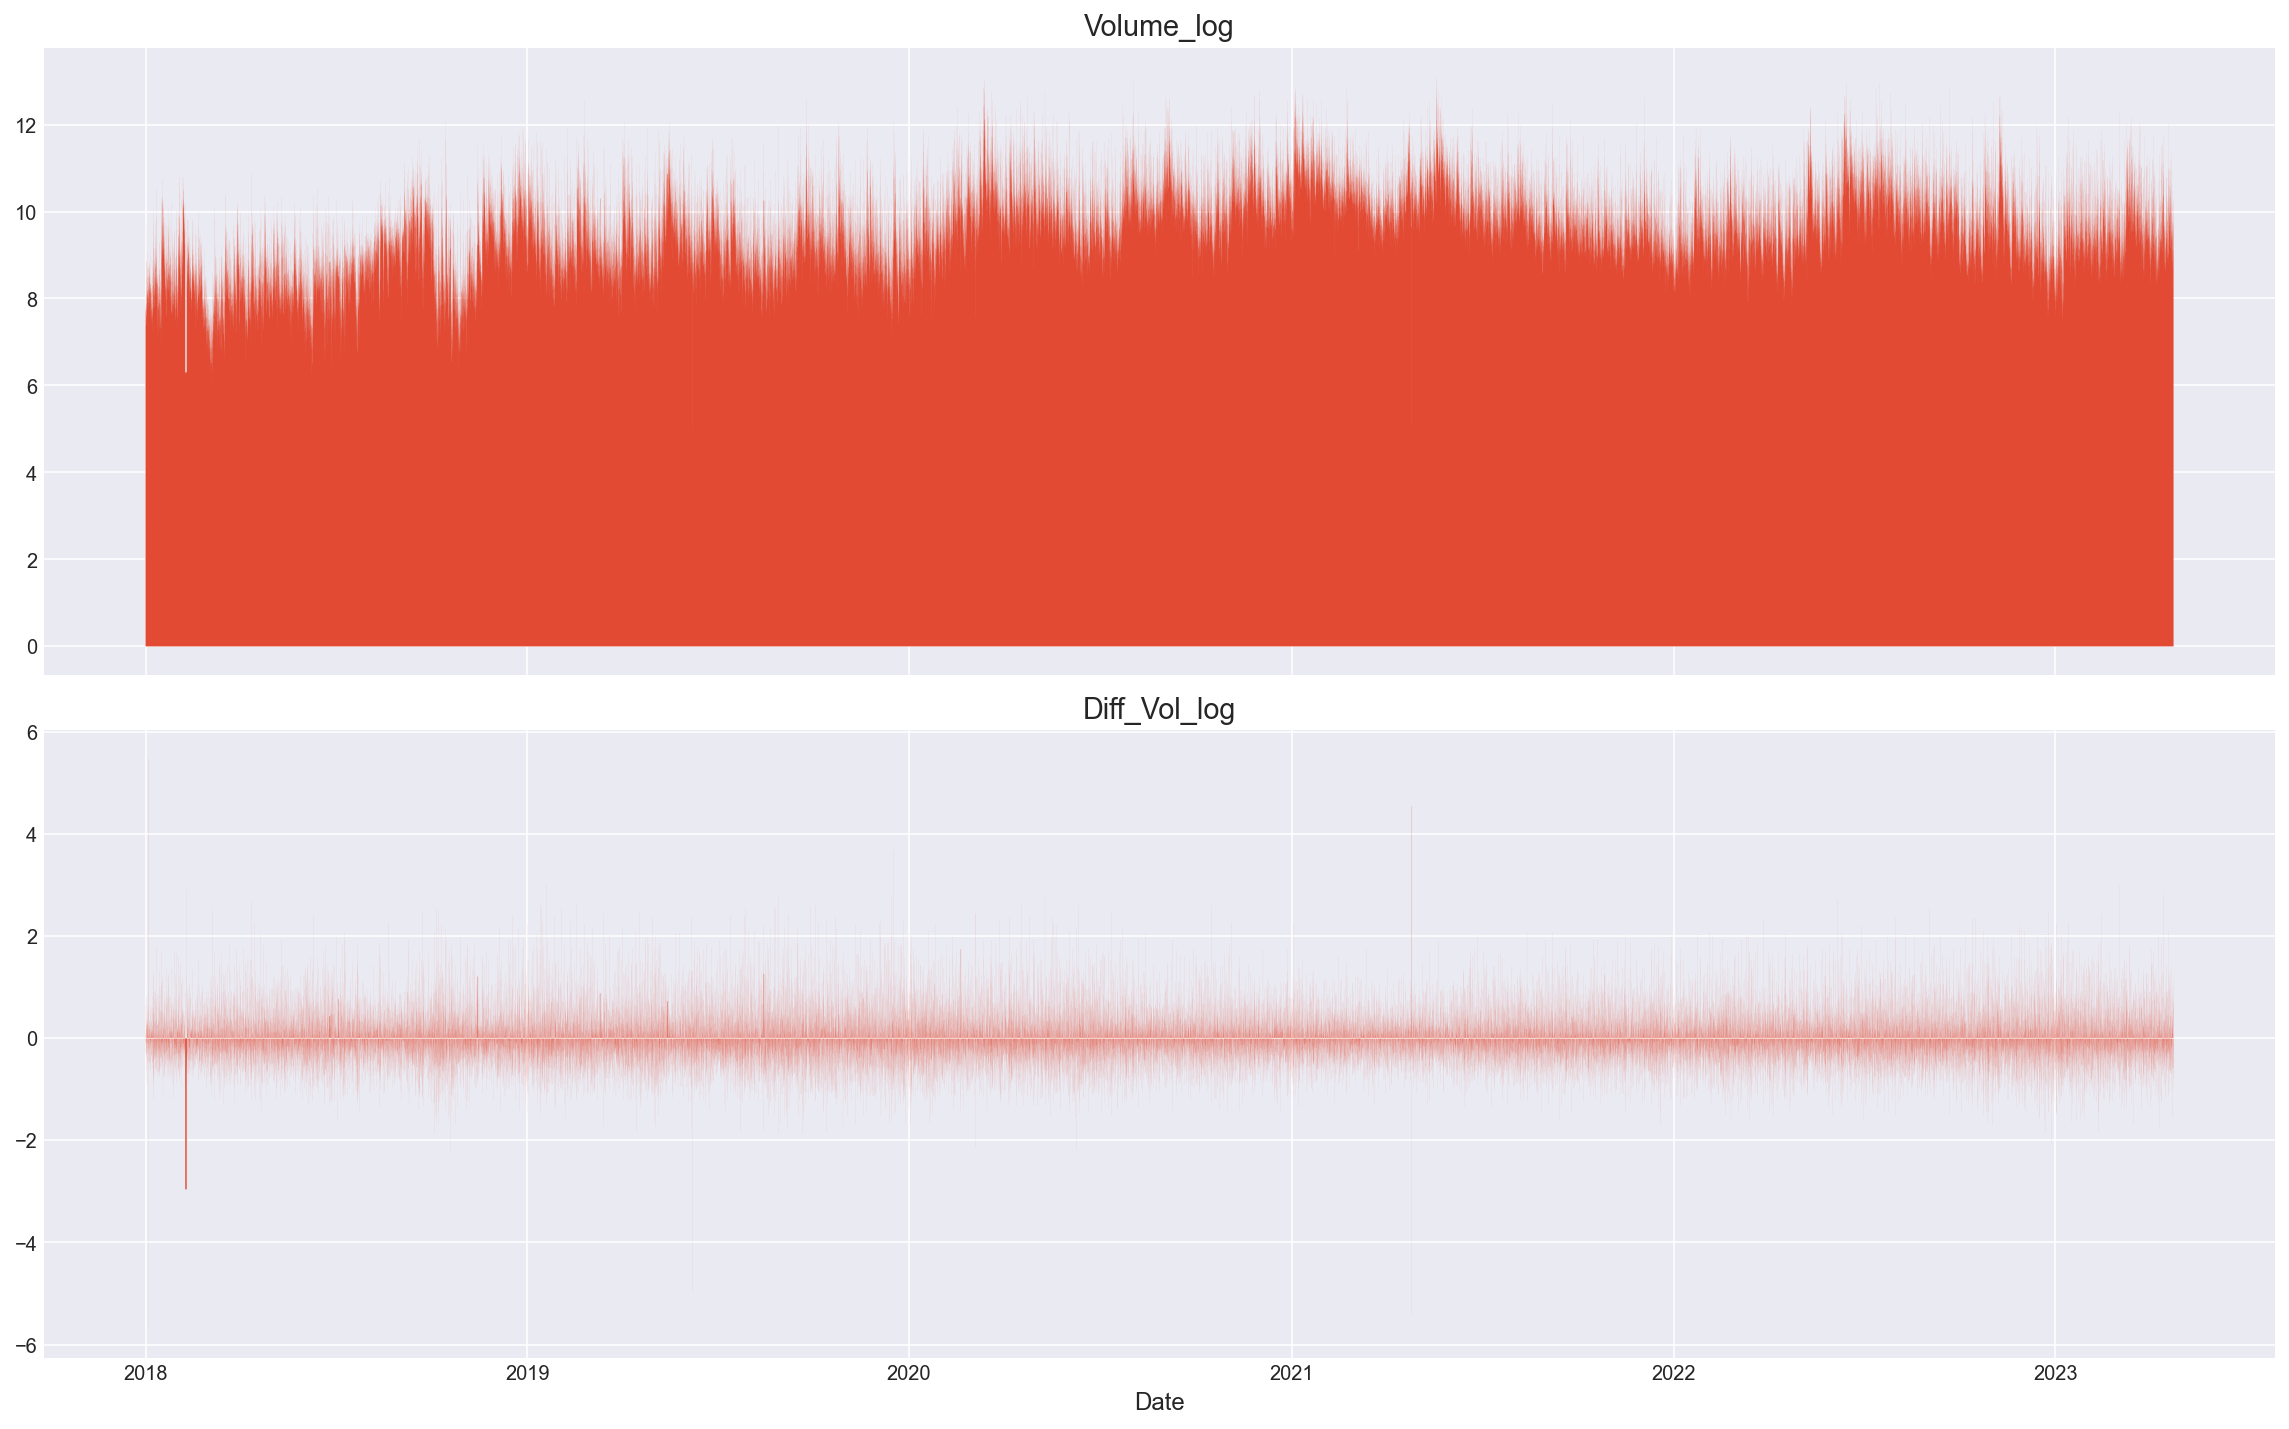

In [19]:
# If need to plot not all data
# df_to_plot = df[df.index >= '2018-01-01']
df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert series to numpy
ind = df_to_plot.index.to_numpy()
_0 = df_to_plot['Volume_log'].to_numpy()
_1 = df_to_plot['Diff_Vol_log'].to_numpy()

ax[0].fill_between(ind, _0, step='pre')
ax[0].set_title('Volume_log')

ax[1].fill_between(ind, _1, step='pre')
ax[1].set_title('Diff_Vol_log')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [20]:
def add_datetime_features(df, as_category=True):
    """Функция для генерации признаков даты/времени из индекса датафрейма

    Args:
        df (_type_): исходный датафрейм
        as_category (bool, optional): Кодидровать ли созданные признаки. Defaults to True.

    Returns:
        _type_: возвращает новый датафрейм
    """
    
    new_df = df.copy()
    
    date_time = new_df.index
    new_df['M'] = date_time.month # Month
    new_df['W'] = date_time.isocalendar().week # Week from year begin
    new_df['MD'] = date_time.day # Day of Month
    new_df['WD'] = date_time.weekday # Day of Week
    new_df['H'] = date_time.hour # Hour
    
    if as_category:
        new_df['M'] = new_df['M'].astype('category')
        new_df['W'] = new_df['W'].astype('category')
        new_df['MD'] = new_df['MD'].astype('category')
        new_df['WD'] = new_df['WD'].astype('category')
        new_df['H'] = new_df['H'].astype('category')
        
    return new_df

In [21]:
df = add_datetime_features(df, as_category=True)

# Create Target Category Feature 
Максимально близко разница подходит к нулю в точке 0.0015 - 4.75

Т.е. текущий случай это:
* risk_level = 0.0015
* risk_factor = 4.75

In [22]:
risk_level = 0.0015
profit_factor = 4.75
profit_level = risk_level * profit_factor
TARGET = 'Long'

In [23]:
zero_mo = hd.profit_margin_for_zero_mo(risk_level, profit_factor)
print('Метрика Precision должна быть выше:', zero_mo)

Метрика Precision должна быть выше: 0.17


In [24]:
df[TARGET] = np.where((df['High_Shad_log'] >= profit_level) & (df['Low_Shad_log'] <= risk_level), 1, 0)

Анализ распределения классов целевого признака

In [25]:
class_df = pd.DataFrame({'%': (df[TARGET].value_counts(True) * 100).round(2), 'Count': df[TARGET].value_counts()})
class_df.index.name = 'Class'
class_df.sort_index(ascending=False, inplace=True)
class_df

,%,Count
Class,,
1,9.64,4475
0,90.36,41936


# Feature Engineering
* Преобразую исходные данные
* Получаю новые признаки. 
* Удаляю ненужные.
* Обогощаю данные.

* Объемы и сделки:
Можно считать средний объем сделки. 
- AvrTrade = Volume / Trades
- Объем в долларах, т.е. нормированный объем VolUSD = Volume * Close
- Объем на единицу диапазона.

### Определяю признаки

In [26]:
# df_new = df[['Log_Return', 'High_Shad_log', 'Low_Shad_log', 'Diff_Vol_log', TARGET]].copy()
df_new = df[['Log_Return', 'High_Shad_log', 'Low_Shad_log', 'Log_Range', 'Body_share', TARGET]].copy()
df_new

,Log_Return,High_Shad_log,Low_Shad_log,Log_Range,Body_share,Long
Datetime,,,,,,
2018-01-01 01:00:00,-0.012512,0.006840,0.014143,0.020984,59.629501,0
2018-01-01 02:00:00,0.008851,0.011196,0.000111,0.011307,78.273806,1
2018-01-01 03:00:00,0.014468,0.019208,0.001728,0.020936,69.104002,0
2018-01-01 04:00:00,0.013286,0.013500,0.006799,0.020299,65.449497,0
2018-01-01 05:00:00,0.005637,0.006984,0.003632,0.010616,53.096068,0
...,...,...,...,...,...,...
2023-04-23 19:00:00,-0.000146,0.003022,0.000997,0.004019,3.637867,0
2023-04-23 20:00:00,0.001299,0.003142,0.004592,0.007734,16.795435,0
2023-04-23 21:00:00,0.003121,0.005631,0.000698,0.006329,49.320075,0


# Временные признаки, которым не нужна глубина

In [27]:
df_time = df[['H', 'WD', TARGET]].copy()

Кодирование категориальных признаков

In [28]:
ohe = OneHotEncoder(cols=['H', 'WD'])
df_time = ohe.fit_transform(df_time)

In [29]:
df_time

,H_1,H_2,H_3,H_4,H_5,H_6,H_7,H_8,H_9,H_10,...,H_23,H_24,WD_1,WD_2,WD_3,WD_4,WD_5,WD_6,WD_7,Long
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2018-01-01 02:00:00,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2018-01-01 03:00:00,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2018-01-01 04:00:00,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2018-01-01 05:00:00,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23 19:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-04-23 20:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-04-23 21:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Transform TimeSeries to Dataset for Supervised Learning
Тут определяется глубина последовательности данных T, которая будет использоваться для построения прогноза. Временное окно в прошлое.

Т это так же гиперпараметр, его так же нужно будет искать по сетке.

In [30]:
# От 2х часов до 7 дней глубина окна для построения прогноза
# t_list = np.arange(2, 170, 2)
t_list = np.arange(1, 49, 1)

precision_train_score_list = []
precision_test_score_list = []

In [31]:
for T in t_list:
    # Create X, y
    X, y, N, D = hd.create_X_y_from_timeseries(df_new, TARGET, T)
    
    # Преобразование временных признаков, где не нужна последовательность, а всего лишь значение на последнем баре
    X_t, y_t, _, _ = hd.create_X_y_from_timeseries(df_time, TARGET, 1)
    
    # Выправляю длину, объединяю признаки
    X_t = X_t[-N:,]
    X = np.concatenate((X, X_t), axis=1)
    
    # Split Data. Разбиение с стратифиацией
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    lr = LogisticRegression(class_weight='balanced')
    lr.fit(X_train, y_train)

    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    
    precision_train = precision_score(y_train, y_train_pred)
    precision_test = precision_score(y_test, y_test_pred)
    
    precision_train_score_list.append(precision_train)
    precision_test_score_list.append(precision_test)

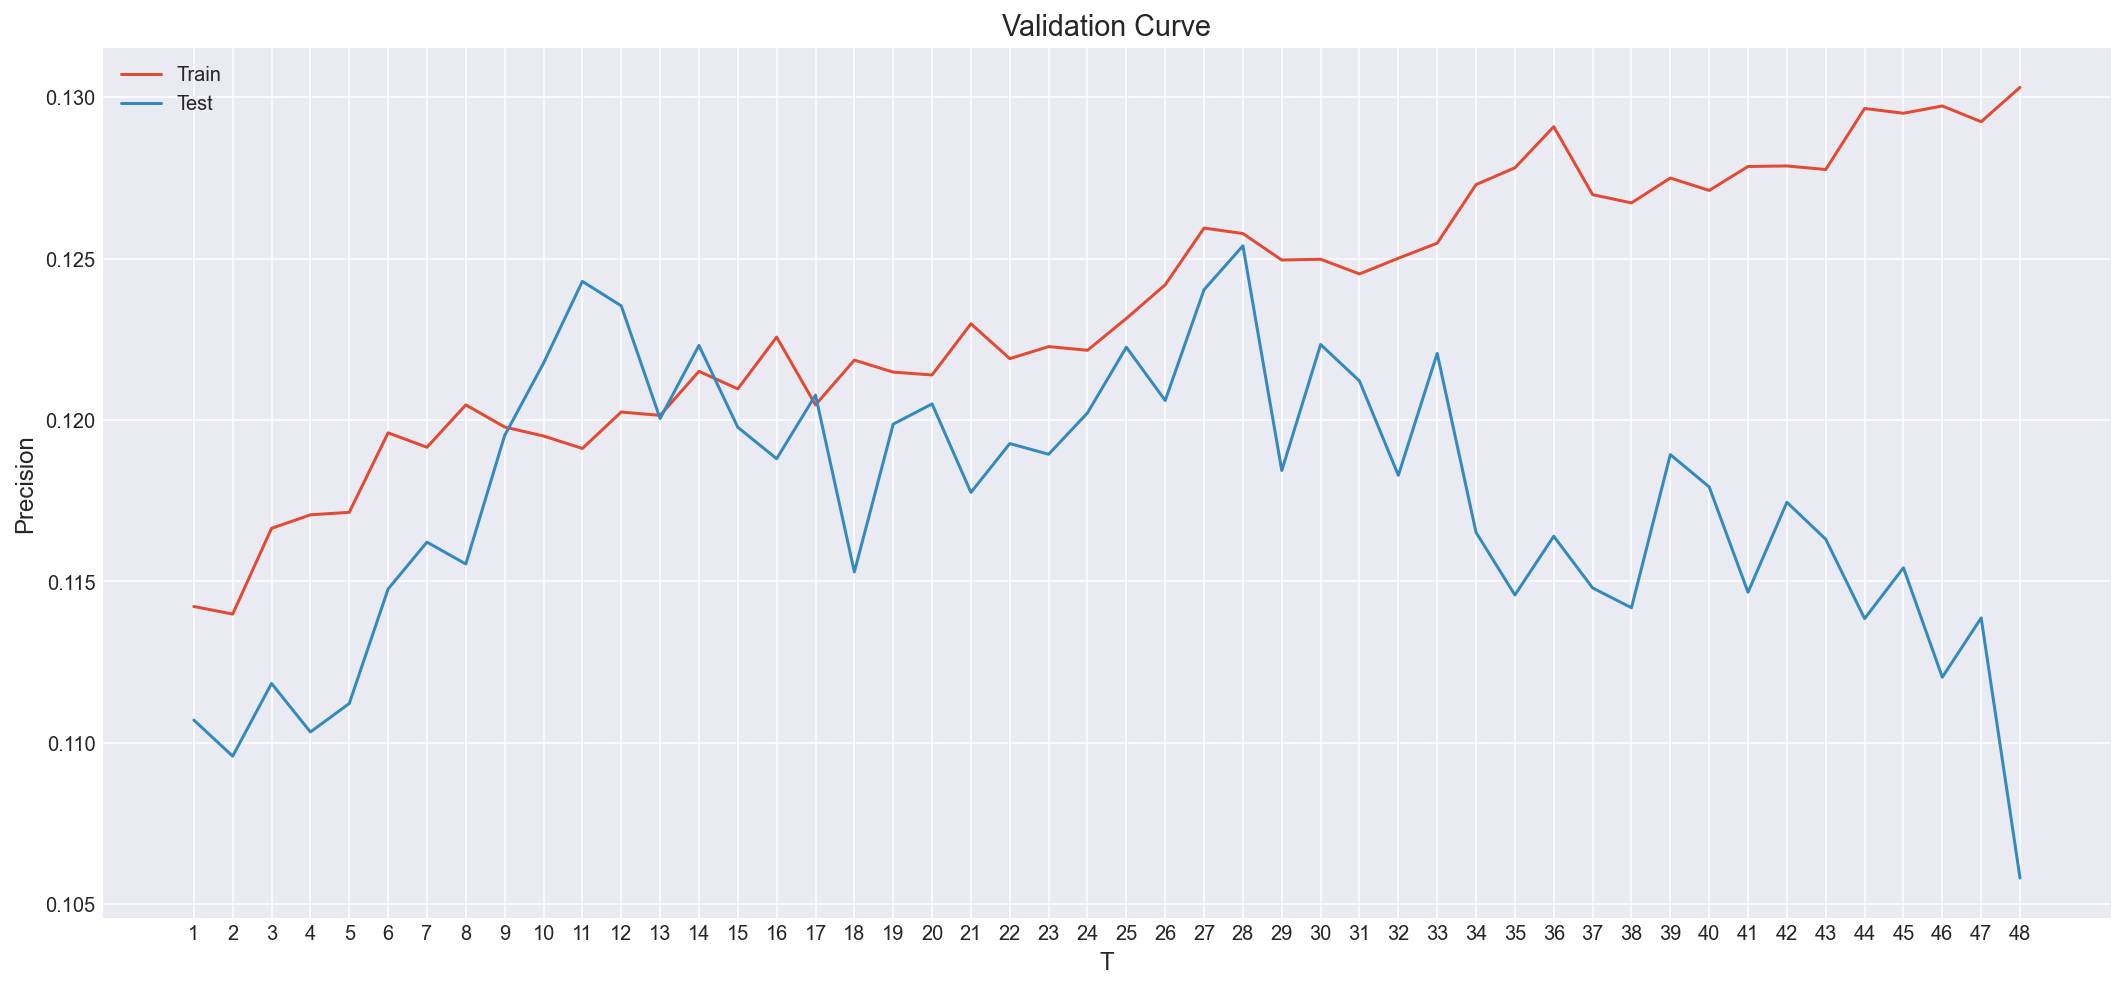

In [32]:
# Визуализируем изменение precision в зависимости от T
fig, ax = plt.subplots(figsize=(18, 8)) # фигура + координатная плоскость
ax.plot(t_list, precision_train_score_list, label='Train') # линейный график для тренировочной выборки
ax.plot(t_list, precision_test_score_list, label='Test') # линейный график для тестовой выборки
ax.set_xlabel('T') # название оси абсцисс
ax.set_ylabel('Precision') # название оси ординат
ax.set_xticks(t_list) # метки по оси абцисс
ax.set_title('Validation Curve')
ax.xaxis.set_tick_params(rotation=0) #п оворот меток на оси абсцисс
ax.legend(); # отображение легенды

Значение Т должно быть либо 12, либо 28 больше нет смысла. Виден оверфиттинг.

In [33]:
T = 27

Create $X$, $y$

In [34]:
X, y, N, D = hd.create_X_y_from_timeseries(df_new, TARGET, T)

In [35]:
print('X.shape:', X.shape, 'y.shape:', y.shape, 'N:', N, 'D:', D)

X.shape: (46384, 135) y.shape: (46384,) N: 46384 D: 5


Преобразование временных признаков, где не нужна последовательность, а всего лишь значение на последнем баре

In [36]:
X_t, y_t, _, _ = hd.create_X_y_from_timeseries(df_time, TARGET, 1)

In [37]:
print('X.shape:', X_t.shape, 'y.shape:', y_t.shape)

X.shape: (46410, 31) y.shape: (46410,)


Выправляю длину, объединяю признаки

In [38]:
X_t = X_t[-N:,]
X = np.concatenate((X, X_t), axis=1)
X.shape

(46384, 166)

# Split Data
Разбиение с стратифиацией

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Outliers
Обработка выбросов. Пробовать прорядить выборку удалением записей по методу:
- 3х сигм
- методу Тьюки
- Isolation Forest
- Local Outlier Factor
- Minimun Covariance Determinant

Но обработку надо делать уже после разделения выборки на train/test

In [40]:
print('X_train:', X_train.shape, 'X_test:', X_test.shape)

X_train: (37107, 166) X_test: (9277, 166)


# Подбор гиперпараметра contamination для IsolationForest

In [41]:
from sklearn.ensemble import IsolationForest

In [42]:
contamination_list = np.arange(0.01, 0.5 + 0.01, 0.01)

# Создаем пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []

for cont_val in contamination_list:
    iso = IsolationForest(contamination=cont_val, random_state=42)
    iso.fit(X_train)

    # ищу аномалии в выборках, в виде векторов новых меток
    train_iso = iso.predict(X_train)
    test_iso = iso.predict(X_test)

    # делаю маски и по ним оставляю лишь те записи, которые не являются выбросами
    train_mask = train_iso != -1
    X_train_iso, y_train_iso = X_train[train_mask], y_train[train_mask]

    test_mask = test_iso != -1
    X_test_iso, y_test_iso = X_test[test_mask], y_test[test_mask]
    
    # Нормализация    
    scaler = StandardScaler()
    X_train_iso = scaler.fit_transform(X_train_iso)
    X_test_iso = scaler.transform(X_test_iso)

    # Создание модели и обучение
    lr = LogisticRegression(class_weight='balanced')
    lr.fit(X_train_iso, y_train_iso)

    # Получение предсказаний
    y_train_iso_pred = lr.predict(X_train_iso)
    y_test_iso_pred = lr.predict(X_test_iso)
       
    # Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(precision_score(y_train_iso, y_train_iso_pred))
    test_scores.append(precision_score(y_test_iso, y_test_iso_pred))

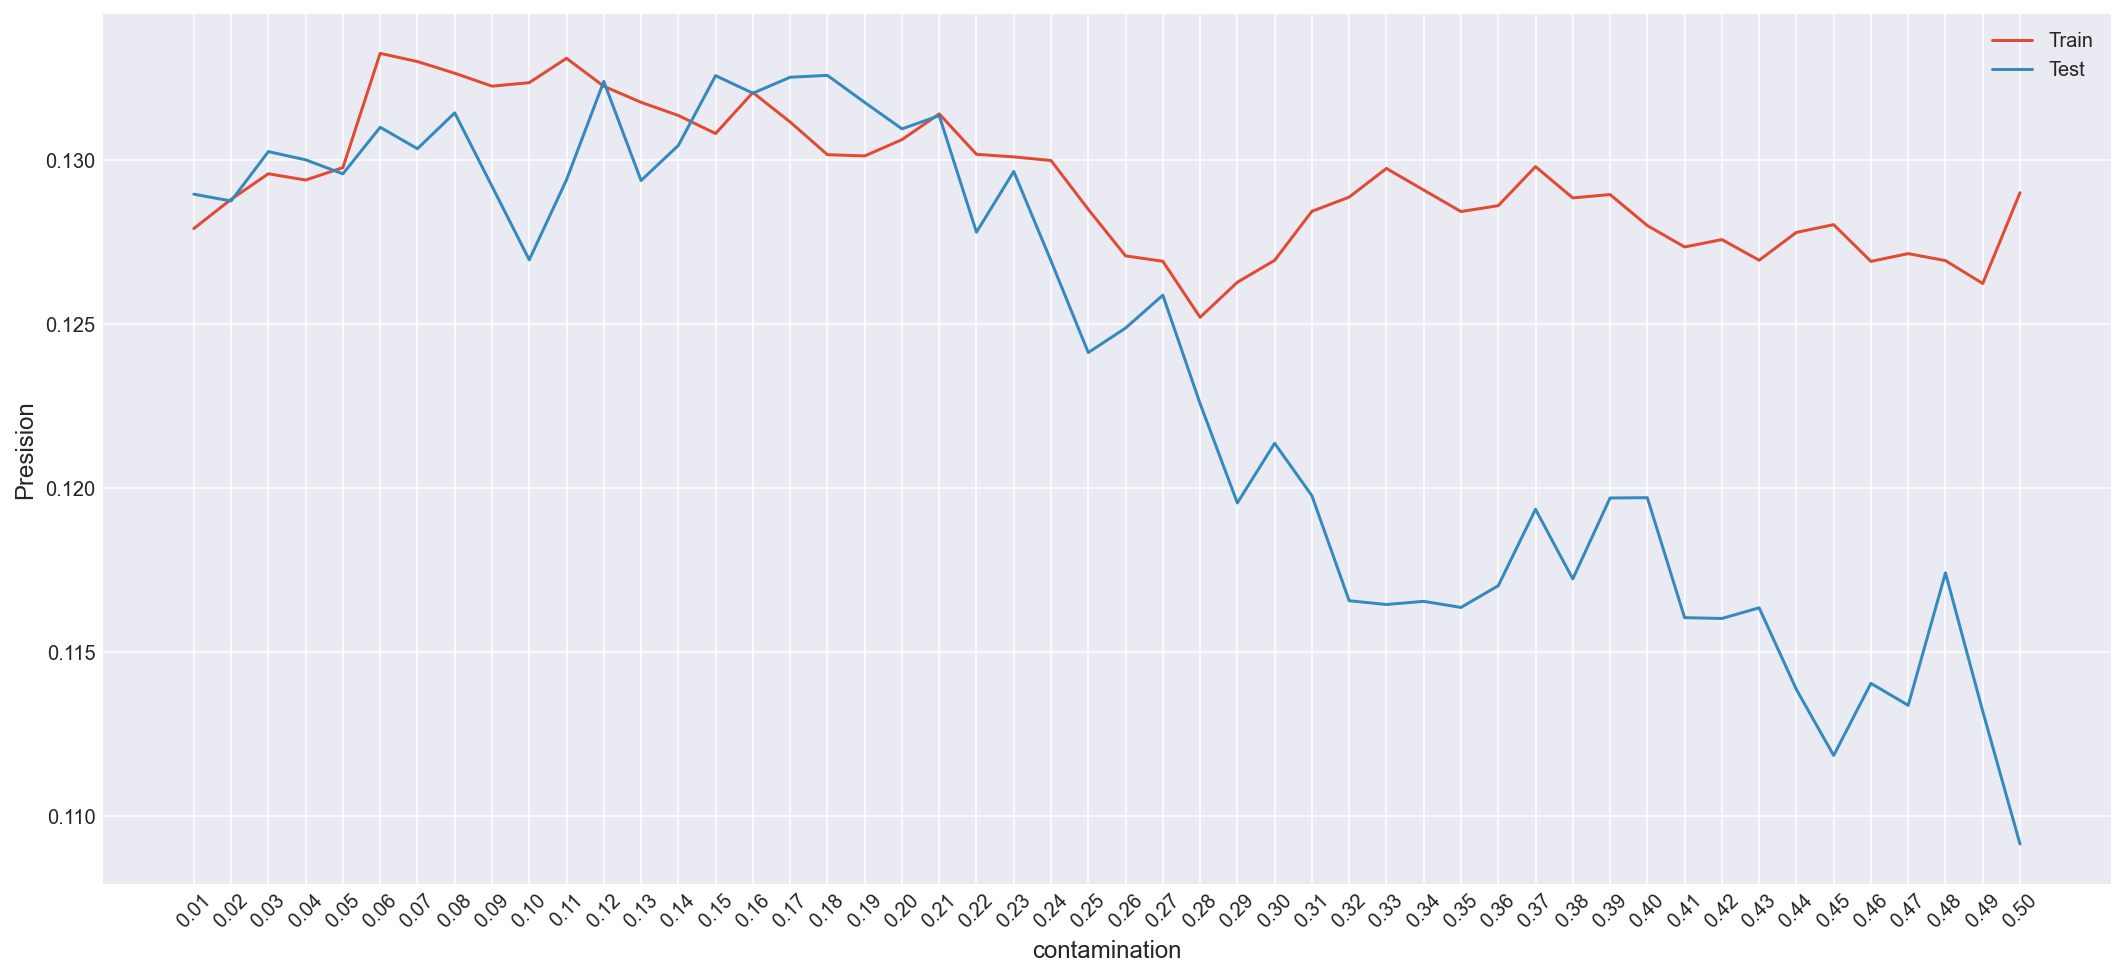

In [43]:
# Визуализируем изменение Presision в зависимости от contamination
fig, ax = plt.subplots(figsize=(18, 8)) # фигура + координатная плоскость
ax.plot(contamination_list, train_scores, label='Train') # линейный график для тренировочной выборки
ax.plot(contamination_list, test_scores, label='Test') # линейный график для тестовой выборки
ax.set_xlabel('contamination') # название оси абсцисс
ax.set_ylabel('Presision') # название оси ординат
ax.set_xticks(contamination_list) # метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) # поворот меток на оси абсцисс
ax.legend(); # отображение легенды

In [44]:
iso = IsolationForest(contamination=0.17, random_state=42)
iso.fit(X_train)

# ищу аномалии в выборках, в виде векторов новых меток
y_train_iso = iso.predict(X_train)
y_test_iso = iso.predict(X_test)

# делаю маски и по ним оставляю лишь те записи, которые не являются выбросами
train_mask = y_train_iso != -1
X_train, y_train = X_train[train_mask], y_train[train_mask]

test_mask = y_test_iso != -1
X_test, y_test = X_test[test_mask], y_test[test_mask]

Как сократились выборки

In [45]:
print('X_train:', X_train.shape, 'X_test:', X_test.shape)

X_train: (30798, 166) X_test: (7619, 166)


# Scaling Data
Нужно скалировать признаки, приводить их к одному масштабу. Путем перебора выбирать лучший скалер.

In [46]:
scaler = StandardScaler()
# scaler = RobustScaler()
# scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create Model

In [47]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [48]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.605
Precision: 0.131
Recall: 0.559
F1: 0.212

*** TEST ***
Accuracy: 0.597
Precision: 0.133
Recall: 0.573
F1: 0.215


In [49]:
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

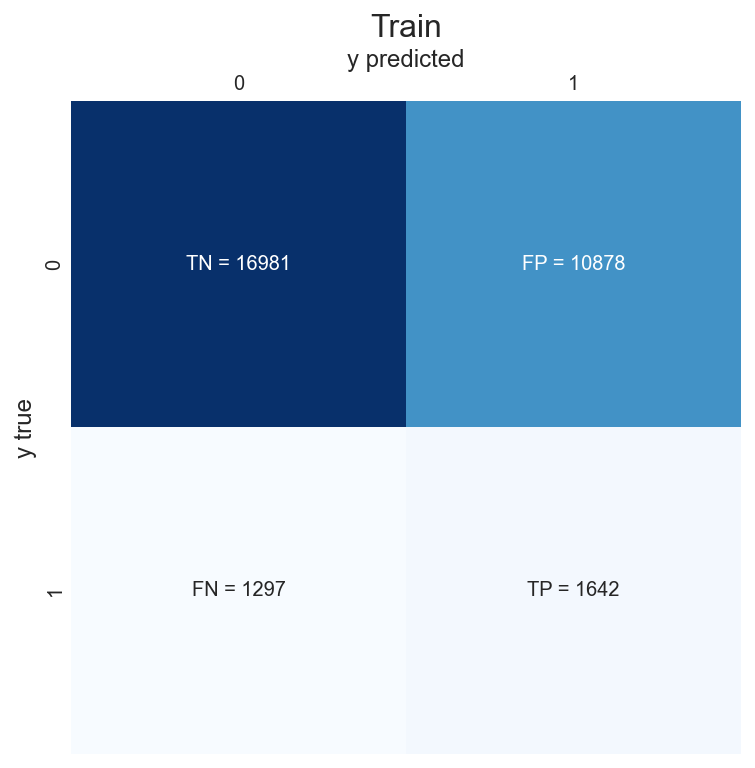

In [50]:
hd.plot_confusion_matrix(cm_train, 'Train')

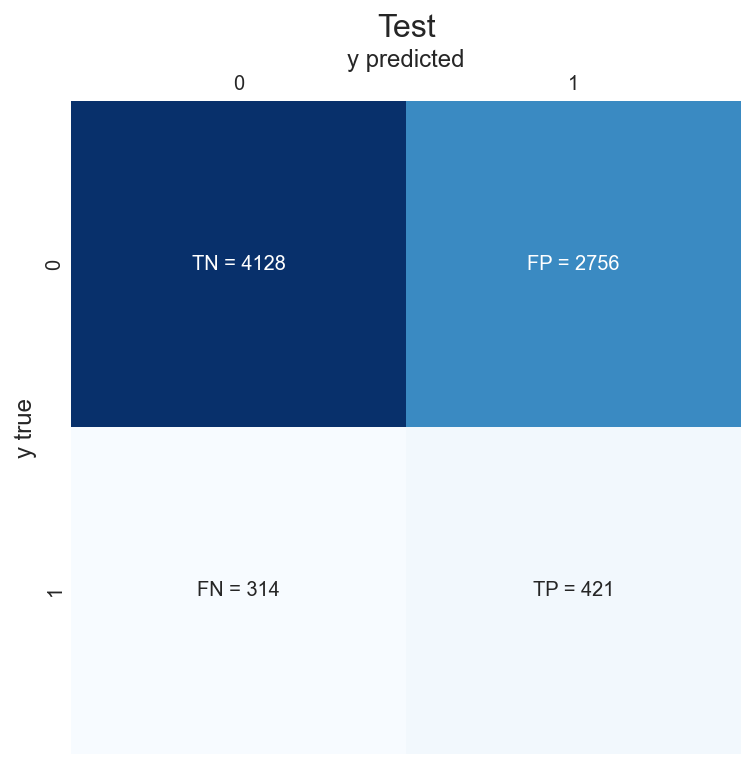

In [51]:
hd.plot_confusion_matrix(cm_test, 'Test')

### Настройка порога вероятности для логистической регрессии

In [52]:
# Тут берем таблицу вероятностей и интересует только вероятность класса 1 (второй столбец)
y_proba_pred = lr.predict_proba(X_test)[:, 1]

# Для удобства завернем numpy-массив в pandas Series
y_proba_pred = pd.Series(y_proba_pred)

# Создадим списки, в которых будем хранить значения метрик
precision_scores = []
recall_scores = []
f1_scores = []

# Сгенерируем набор вероятностных порогов в диапазоне от 0.05 до 1
thresholds = np.arange(0.3, 1 + 0.01, 0.01)

# В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # Пациентов, для которых вероятность наличия диабета > threshold относим к классу 1
    # В противном случае - к классу 0
    y_pred = y_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # Считаем метрики и добавляем их в списки
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

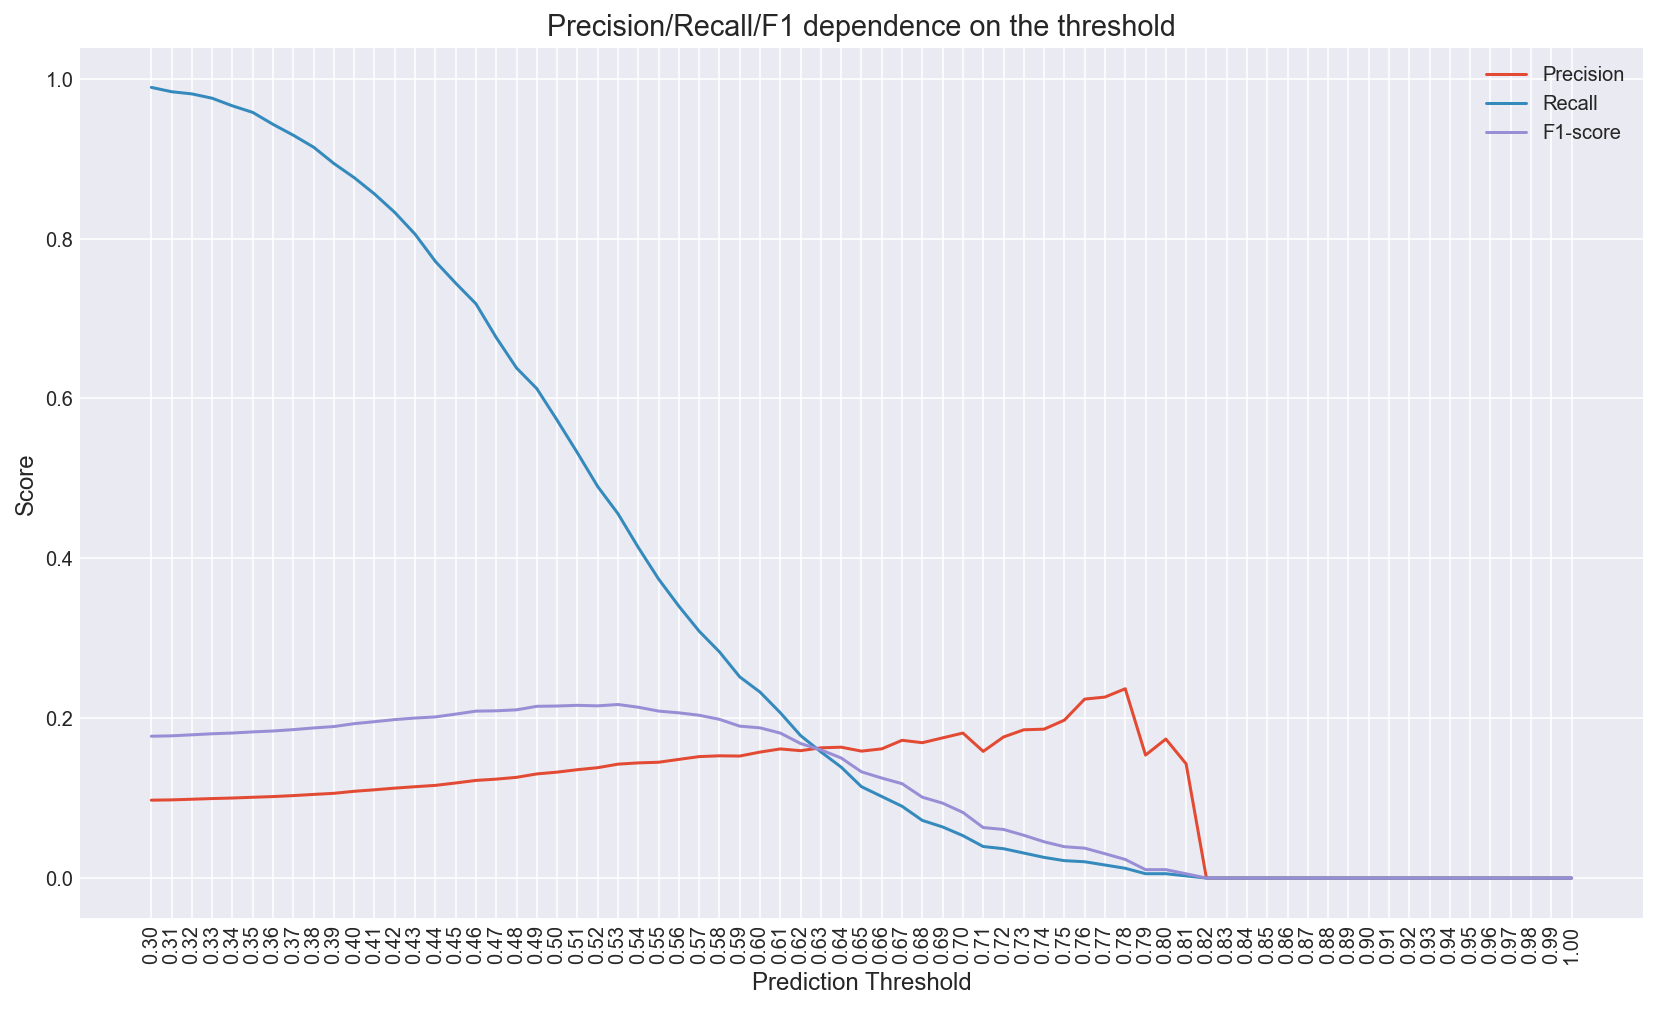

In [53]:
# Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(14, 8)) # фигура + координатная плоскость
# Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
# Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
# Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# Даем графику название и подписи осям
ax.set_title('Precision/Recall/F1 dependence on the threshold')
ax.set_xlabel('Prediction Threshold')
ax.set_ylabel('Score')
# Устанавливаем отметки по оси x
ax.set_xticks(thresholds)
ax.tick_params(axis='x', labelrotation=90)
# Отображаем легенду
ax.legend();

In [54]:
# Задаем оптимальный порог вероятностей для максимизации Precision
threshold_opt = 0.67

y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
# Считаем метрики
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      6884
         1.0       0.17      0.09      0.12       735

    accuracy                           0.87      7619
   macro avg       0.54      0.52      0.52      7619
weighted avg       0.84      0.87      0.85      7619



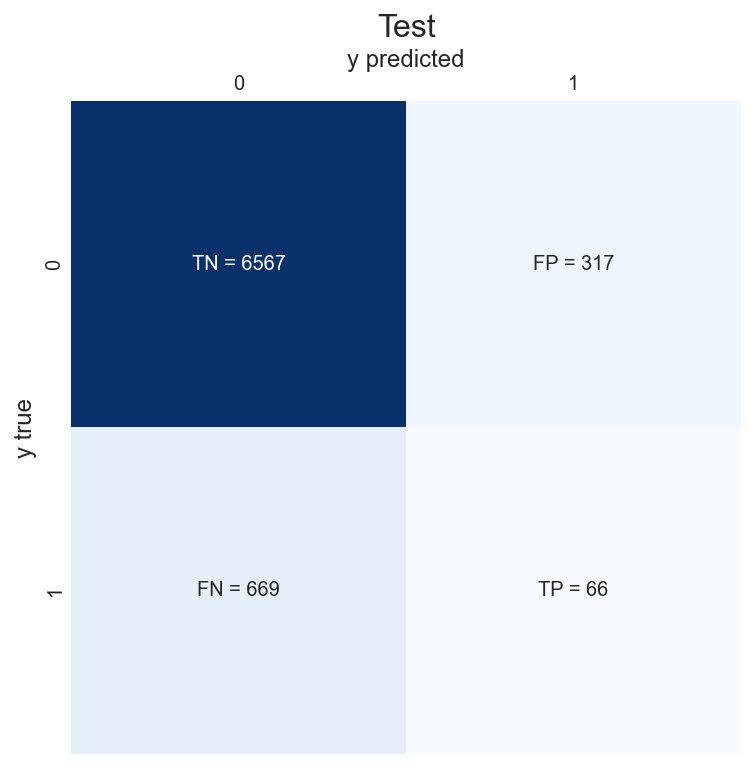

In [55]:
cm_test = confusion_matrix(y_test, y_pred_opt)
hd.plot_confusion_matrix(cm_test, 'Test')

In [56]:
print(f'Сделка каждые {X_test.shape[0]//(cm_test[0, 1] + cm_test[1, 1])} часов')
print(f'Сделок в месяц {30 * 24 // (X_test.shape[0] / (cm_test[0, 1] + cm_test[1, 1])):.0f}')

Сделка каждые 19 часов
Сделок в месяц 36
